<a href="https://colab.research.google.com/github/syifanurul/Malaria-Cells-Image-Recognition/blob/master/Malaria_Cell_Image_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MALARIA CELLS IMAGE RECOGNITION**

Classification of Malaria Cells Identification in Red Blood Cells Using Tensorflow


**Group Members:** 
1. Raynald Masli
2. Syifa Nurul Fatimah

## **Import Packages**

In [0]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import os
import cv2
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## **Download Data from Kaggle**

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raynaldmasli","key":"f0b16ad96cd92fe3c64f0b6430d2907b"}'}

In [0]:
!ls -lha kaggle.json #Make sure that kaggle.json has already upload

-rw-r--r-- 1 root root 68 Apr  3 17:07 kaggle.json


In [0]:
!pip install -q kaggle #kaggle library installation

In [0]:
#Access the Kaggle dataset for data input
!mkdir -p~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list #Asking for Kaggle dataset


mkdir: invalid option -- '~'
Try 'mkdir --help' for more information.
ref                                                            title                                                size  lastUpdated          downloadCount  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge              COVID-19 Open Research Dataset Challenge (CORD-19)  729MB  2020-03-27 23:46:53          41124  
ryanxjhan/cbc-news-coronavirus-articles-march-26               CBC News Coronavirus/COVID-19 Articles (NLP)          6MB  2020-03-27 23:23:07            245  
vitaliymalcev/russian-passenger-air-service-20072020           Russian passenger air service 2007-2020             239KB  2020-04-02 22:27:03            161  
danevans/world-bank-wdi-212-health-systems                     World Bank WDI 2.12 - Health Systems                  6KB  2020-03-29 19

In [0]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria #malaria-cells-images download from Kaggle

 99% 666M/675M [00:06<00:00, 97.0MB/s]
100% 675M/675M [00:06<00:00, 115MB/s] 


## **Data Preparation**

In [0]:

import zipfile

#Extract the file from zip file
images = zipfile.ZipFile("/content/cell-images-for-detecting-malaria.zip", 'r')
images.extractall("/content")
images.close()


In [0]:
#Assign the images into either the infected cells and uninfected cells 

infected_cells = os.listdir("/content/cell_images/Parasitized")
uninfected_cells = os.listdir("/content/cell_images/Uninfected")

In [0]:
#Transform and resize the all the images into the 75x75 matrices of pixels
import keras.preprocessing.image as im
picture = []
label = []

for infect in infected_cells :
  try :
    if infect != 'Thumbs.db':
      image = "/content/cell_images/Parasitized/"+infect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(1)

  except FileNotFoundError:
    continue

for uninfect in uninfected_cells :
  try :
    if uninfect != 'Thumbs.db':
      image = "/content/cell_images/Uninfected/"+uninfect
      img_array = im.img_to_array(im.load_img(image, target_size = (75,75), interpolation = 'nearest'), dtype = 'uint8')
      picture.append(np.array(img_array))
      label.append(0)

  except FileNotFoundError:
    continue


Using TensorFlow backend.


In [0]:
#Initialization of image data parameters
data = np.array(picture)
labels = np.array(label)

#Checks the total of rgb images array and the labels of them
np.save('data', data)
np.save('labels', labels)

print ('data : {}, labels : {}'.format(data.shape, labels.shape))

data : (27558, 75, 75, 3), labels : (27558,)


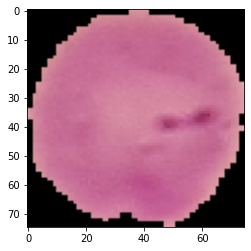

In [0]:
#Plot an example of the data
plt.imshow(data[3])

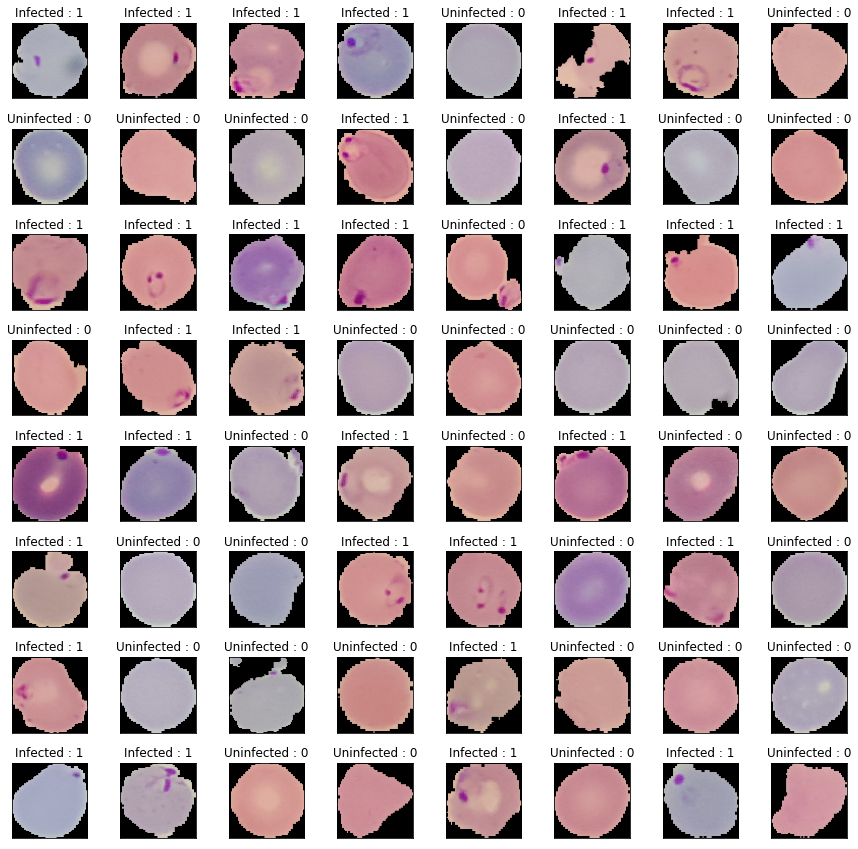

In [0]:
#Plot and preview the pictures and its label
plt.figure(num = 1, figsize = (15,15))

for n in range (1,65) :
  val = np.random.randint(0, data.shape[0], 1)
  plt.subplot(8, 8, n)
  plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
  plt.imshow(data[val[0]])
  plt.title('{} : {}'.format('Uninfected' if labels[val[0]] == 0 else 'Infected', labels[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()

In [0]:
#Data Randomization
arranger = np.arange(data.shape[0])
np.random.shuffle(arranger)
data = data[arranger]
labels = labels[arranger]

# **Data Preparation Conclusion**


*   Images are transformed into 75x75 pixels matrix in feature 'data' 
*   Labels of the images (infected and uninfected) is determined in feature 'labels'
*   All the dataset has been randomized





## **Model Creation**

1.   Training and testing dataset 

2.   Build the model

3.   Model summary

3.   Compile the model

4.   Train and test the model

5.   Save the model

6.   Visualize training result

7.   Evaluate the model performance on test set

8.   Visualize the evaluation results



### **Training and Tesing Dataset**

In [0]:
#Split the data into training and testing dataset
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size = 0.25)

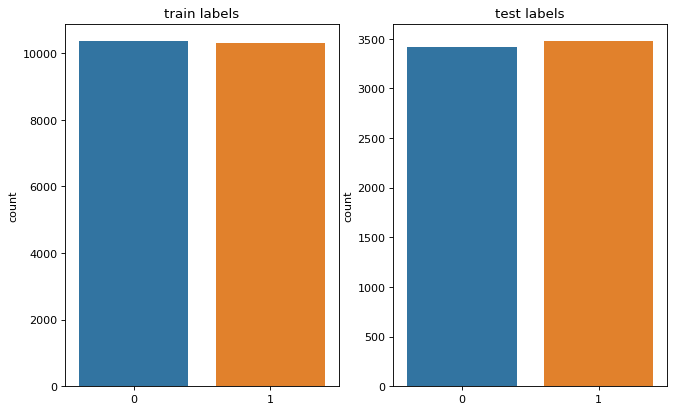

In [0]:
#Data amount confirmation
plt.figure(1, figsize = (15,6), dpi = 80)
num_fig = 0

for pic, title in zip ([Y_train, Y_test], ['train labels', 'test labels']) :
  num_fig += 1
  plt.subplot(1, 3, num_fig)
  sb.countplot (x = pic)
  plt.title(title)

plt.show()

### **Build the Model**

In [0]:
#Create model with function
def Convmodel (filllayer, mode = 'relu'):


#There are 3 functions that is used in the convolutional layer and the dense layer,
#In this function, those three function can be selected in order to get more robust prediction
#The functions are : ReLU, Leaky ReLU, and PReLU function 
#Resource: Nwankpa, Chigozie Enyinna, et. al, 2018, Activation Functions: Comparisons Of Trends in Practice and Research for Deep Learning, arXiv Journal, pp. 1-20

  model = Sequential()
  model.add(Conv2D(filllayer.pop(0), (3,3), input_shape = (75,75,3)))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : model.add(PReLU(Constant(value = 0.25)))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\',and \'prelu\'')

  for i,neurons in enumerate (filllayer):  
    model.add(Conv2D(neurons, (3,3), input_shape = (75,75,3)))
    if mode == 'relu' : model.add(Activation('relu'))  
    elif mode == 'leakyrelu' : model.add(LeakyReLU())
    elif mode == 'prelu' : model.add(PReLU(Constant(value = 0.25)))
    else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
    model.add(MaxPooling2D((2,2)))

  model.add(Flatten())
  model.add(Dense(512))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : model.add(PReLU(Constant(value = 0.25)))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dropout(0.5))
  model.add(Dense(64))
  if mode == 'relu' : model.add(Activation('relu'))  
  elif mode == 'leakyrelu' : model.add(LeakyReLU())
  elif mode == 'prelu' : model.add(PReLU(Constant(value = 0.25)))
  else : raise AttributeError(
      'mode only has 3 methods \'relu\', \'leakyrelu\', and \'prelu\'')
  model.add(Dense(1, activation = 'sigmoid'))

  return model

### **Model Summary**

In [0]:
#Deep learning model creation for leakyrelu mode
model1 = Convmodel([32,64,128,256,512], mode = 'leakyrelu')
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 33, 33, 128)       0

In [0]:
#Depp learning model creation for relu mode
model2 = Convmodel([32,64,128,256,512], mode = 'relu')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 73, 73, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 71, 71, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 33, 33, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 33, 33, 128)      

In [0]:
#Deep learning model creation for prelu mode
model3 = Convmodel([32,64,128,256,512], mode = 'prelu')
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 73, 73, 32)        896       
_________________________________________________________________
p_re_lu (PReLU)              (None, 73, 73, 32)        170528    
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 71, 71, 64)        18496     
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 71, 71, 64)        322624    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 33, 33, 128)       73856     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 33, 33, 128)      

### **Compile the Model**

In [0]:
model1.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])
model2.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])
model3.compile(loss = 'binary_crossentropy', optimizer = optimizers.Adam(learning_rate = 0.001),
                   metrics=['accuracy'])

### **Train and Test the Model**

In [0]:
batch_size = 32 #The batch size chosen is 32 data per batch
epochs = 30
ntrain = len(X_train)
nval = len(X_test)

In [0]:
#Image augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1/225, horizontal_flip = True, vertical_flip = True, rotation_range = 30)

In [0]:
train_datagen = train_datagen.flow(X_train, Y_train, batch_size = batch_size)

In [0]:
history1 = model1.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
645/645 [==============================] - 32s 50ms/step - loss: 0.3540 - accuracy: 0.8432
Epoch 2/30
645/645 [==============================] - 33s 52ms/step - loss: 0.2277 - accuracy: 0.9227
Epoch 3/30
645/645 [==============================] - 34s 53ms/step - loss: 0.2207 - accuracy: 0.9244
Epoch 4/30
645/645 [==============================] - 34s 52ms/step - loss: 0.2098 - accuracy: 0.9295
Epoch 5/30
645/645 [==============================] - 35s 54ms/step - loss: 0.2029 - accuracy: 0.9306
Epoch 6/30
645/645 [==============================] - 33s 51ms/step - loss: 0.1988 - accuracy: 0.9331
Epoch 7/30
645/645 [==============================] - 33s 51ms/step - loss: 0.2004 - accuracy: 0.9307
Epoch 8/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1936 - accuracy: 0.9326
Epoch 9/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1886 - accuracy: 0.9343
Epoch 

In [0]:
history2 = model2.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Epoch 1/30
645/645 [==============================] - 31s 48ms/step - loss: 0.4121 - accuracy: 0.7908
Epoch 2/30
645/645 [==============================] - 31s 47ms/step - loss: 0.2341 - accuracy: 0.9217
Epoch 3/30
645/645 [==============================] - 30s 47ms/step - loss: 0.2206 - accuracy: 0.9243
Epoch 4/30
645/645 [==============================] - 31s 47ms/step - loss: 0.2154 - accuracy: 0.9265
Epoch 5/30
645/645 [==============================] - 31s 47ms/step - loss: 0.2013 - accuracy: 0.9305
Epoch 6/30
645/645 [==============================] - 30s 47ms/step - loss: 0.1974 - accuracy: 0.9318
Epoch 7/30
645/645 [==============================] - 30s 47ms/step - loss: 0.1971 - accuracy: 0.9303
Epoch 8/30
645/645 [==============================] - 31s 48ms/step - loss: 0.1880 - accuracy: 0.9322
Epoch 9/30
645/645 [==============================] - 31s 47ms/step - loss: 0.1889 - accuracy: 0.9324
Epoch 10/30
645/645 [==============================] - 30s 47ms/step - loss: 0.182

In [0]:
history3 = model3.fit_generator(train_datagen,
                              steps_per_epoch = ntrain // batch_size,
                              epochs = epochs)

Epoch 1/30
645/645 [==============================] - 33s 50ms/step - loss: 0.3294 - accuracy: 0.8663
Epoch 2/30
645/645 [==============================] - 33s 51ms/step - loss: 0.2229 - accuracy: 0.9252
Epoch 3/30
645/645 [==============================] - 33s 51ms/step - loss: 0.2094 - accuracy: 0.9306
Epoch 4/30
645/645 [==============================] - 33s 51ms/step - loss: 0.2076 - accuracy: 0.9299
Epoch 5/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1977 - accuracy: 0.9348
Epoch 6/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1878 - accuracy: 0.9359
Epoch 7/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1950 - accuracy: 0.9317
Epoch 8/30
645/645 [==============================] - 32s 50ms/step - loss: 0.1846 - accuracy: 0.9374
Epoch 9/30
645/645 [==============================] - 32s 49ms/step - loss: 0.1816 - accuracy: 0.9374
Epoch 10/30
645/645 [==============================] - 32s 50ms/step - loss: 0.172

### **Save the Model**

In [0]:
model1.save_weights('model_weights.1')
model1.save('model_keras.1')
model2.save_weights('model_weights.1')
model2.save('model_keras.1')
model3.save_weights('model_weights.1')
model3.save('model_keras.1')

INFO:tensorflow:Assets written to: model_keras.1/assets
INFO:tensorflow:Assets written to: model_keras.1/assets
INFO:tensorflow:Assets written to: model_keras.1/assets


### **Visualize Training Result**

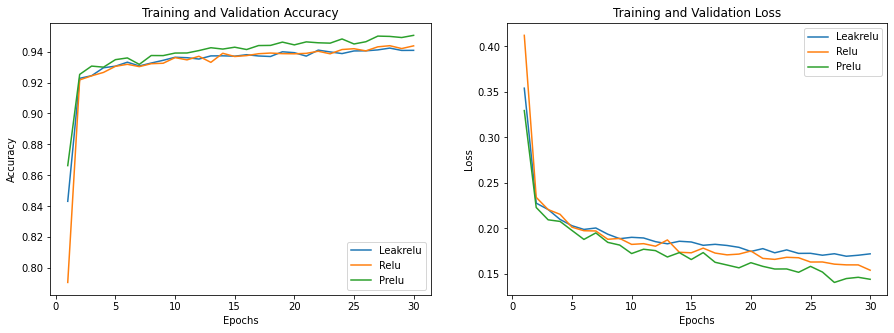

In [0]:
#Plot the training accuracy and loss
acc1 = history1.history['accuracy']
loss1 = history1.history['loss']
acc2 = history2.history['accuracy']
loss2 = history2.history['loss']
acc3 = history3.history['accuracy']
loss3 = history3.history['loss']

epochs_range = range(1, len(acc1) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc1, label='Leakrelu')
plt.plot(epochs_range, acc2, label='Relu')
plt.plot(epochs_range, acc3, label='Prelu')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss1, label='Leakrelu')
plt.plot(epochs_range, loss2, label='Relu')
plt.plot(epochs_range, loss3, label='Prelu')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


#for met, col, ylab, title in zip ([acc1, loss1], ['red', 'green'], ['Accuracy', 'Loss'], ['Training Accuracy', 'Training Loss']):
#  plt.figure(figsize = (15,5))
#  num_fig += 1
#  plt.subplot(1,2, num_fig)
#  plt.plot(epochs_range, met, col)
#  plt.title(title)
#  plt.xlabel('Epochs')
#  plt.ylabel(ylab)

#plt.show()

Test Accuracy 
 Leakrelu = 92.61% 
 Relu = 64.01% 
 Prelu = 93.69%
Test Prediction 
 Leakrelu = 95.66% 
 Relu = 97.24% 
 Prelu = 93.38%
Test Recall 
 Leakrelu = 90.28% 
 Relu = 58.64% 
 Prelu = 94.06%
Test f1 Score 
 Leakrelu = 92.89% 
 Relu = 73.16% 
 Prelu = 93.72%


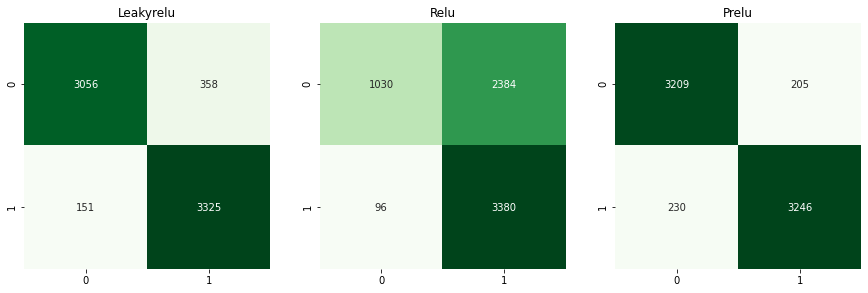

In [0]:
#Test result conclusion
import tensorflow.keras.metrics as mts
def conc_model(model1, model2, model3):
  plt.figure(figsize = (15,5))
  #model1
  plt.subplot(1, 3, 1)
  y_pred_1 = model1.predict(X_test)
  y_pred_1 = np.where(y_pred_1 > 0.5, 1, 0)
  conf_matrix_1 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_1))
  acc_1 = (conf_matrix_1[0,0] + conf_matrix_1[1,1])/(conf_matrix_1[0,0] + conf_matrix_1[1,1] + conf_matrix_1[1,0] + conf_matrix_1[0,1])*100
  prec_1 = conf_matrix_1[1,1]/(conf_matrix_1[1,1] + conf_matrix_1[1,0])*100
  rec_1 = conf_matrix_1[1,1]/(conf_matrix_1[1,1] + conf_matrix_1[0,1])*100
  f1_score_1 = 2*prec_1*rec_1/(prec_1 + rec_1)
  sb.heatmap(conf_matrix_1, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Leakyrelu')
  #model2
  plt.subplot(1, 3, 2)
  y_pred_2 = model2.predict(X_test)
  y_pred_2 = np.where(y_pred_2 > 0.5, 1, 0)
  conf_matrix_2 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_2))
  acc_2 = (conf_matrix_2[0,0] + conf_matrix_2[1,1])/(conf_matrix_2[0,0] + conf_matrix_2[1,1] + conf_matrix_2[1,0] + conf_matrix_2[0,1])*100
  prec_2 = conf_matrix_2[1,1]/(conf_matrix_2[1,1] + conf_matrix_2[1,0])*100
  rec_2 = conf_matrix_2[1,1]/(conf_matrix_2[1,1] + conf_matrix_2[0,1])*100
  f1_score_2 = 2*prec_2*rec_2/(prec_2 + rec_2)
  sb.heatmap(conf_matrix_2, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Relu')
  #model3
  plt.subplot(1, 3, 3)
  y_pred_3 = model3.predict(X_test)
  y_pred_3 = np.where(y_pred_3 > 0.5, 1, 0)
  conf_matrix_3 = np.array(tf.math.confusion_matrix(labels = Y_test, predictions = y_pred_3))
  acc_3 = (conf_matrix_3[0,0] + conf_matrix_3[1,1])/(conf_matrix_3[0,0] + conf_matrix_3[1,1] + conf_matrix_3[1,0] + conf_matrix_3[0,1])*100
  prec_3 = conf_matrix_3[1,1]/(conf_matrix_3[1,1] + conf_matrix_3[1,0])*100
  rec_3 = conf_matrix_3[1,1]/(conf_matrix_3[1,1] + conf_matrix_3[0,1])*100
  f1_score_3 = 2*prec_3*rec_3/(prec_3 + rec_3)
  sb.heatmap(conf_matrix_3, fmt = 'd', annot = True, square = True, cbar = False, cmap = 'Greens')
  plt.title('Prelu')
  print('Test Accuracy \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(acc_1, acc_2, acc_3))
  print('Test Prediction \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(prec_1, prec_2, prec_3))
  print('Test Recall \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(rec_1, rec_2, rec_3))
  print('Test f1 Score \n Leakrelu = {:.2f}% \n Relu = {:.2f}% \n Prelu = {:.2f}%'.format(f1_score_1,f1_score_2,f1_score_3))
  plt.show()

conc_model(model1,model2,model3)

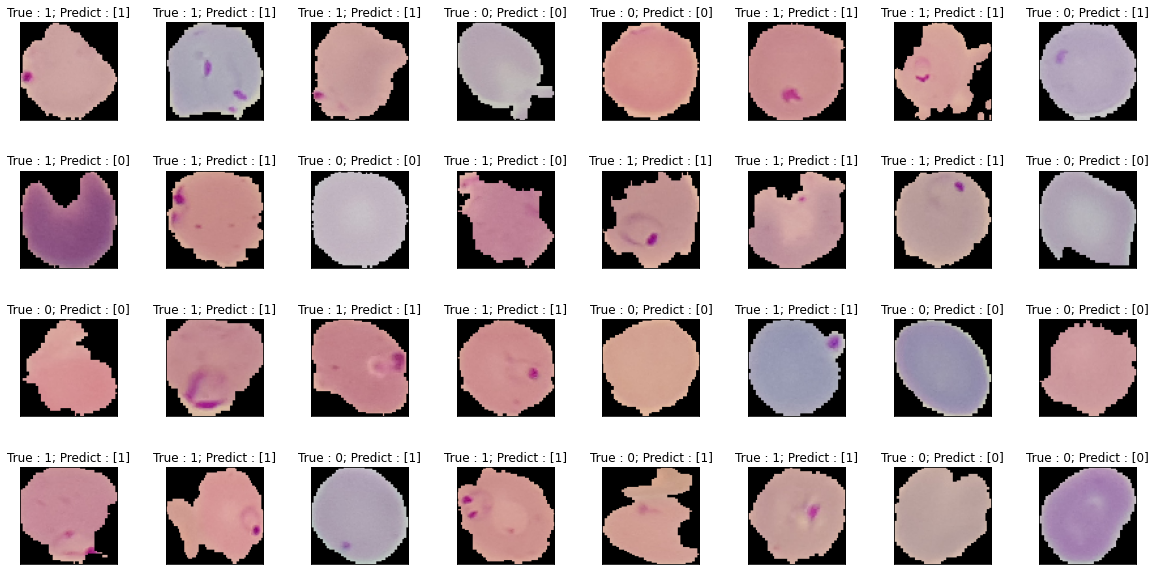

In [0]:
#plot the train test result
y_pred = model3.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)

plt.figure(num = 1, figsize = (20,10))

for n in range (1,33) :
  val = np.random.randint(0, X_test.shape[0], 1)
  plt.subplot(4, 8, n)
  plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
  plt.imshow(X_test[val[0]])
  plt.title('True : {}; Predict : {}'.format(Y_test[val[0]], y_pred[val[0]]))
  plt.yticks([])
  plt.xticks([])

plt.show()